In [1]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
from transformers.pipelines import pipeline
import matplotlib.pyplot as plt
from bertopic.representation import TextGeneration
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /home/jstet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv("./data/sample.csv")

In [3]:
# calculate mean length of text in words
df["length"] = df["description"].apply(lambda x: len(x.split()))
print(df["length"].describe())

count     399.000000
mean       93.636591
std       116.146787
min         3.000000
25%        26.000000
50%        45.000000
75%       117.000000
max      1120.000000
Name: length, dtype: float64


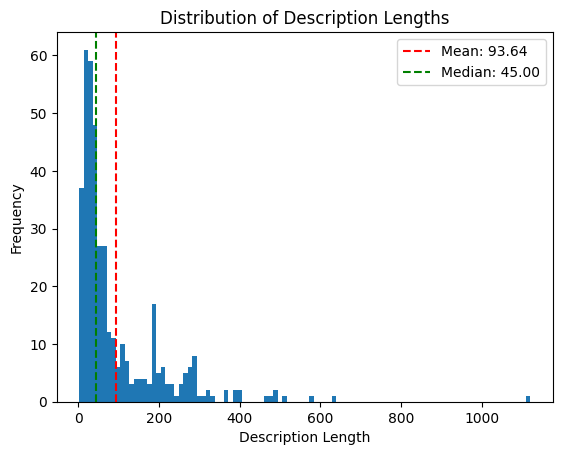

In [4]:
plt.hist(df["length"], bins=100)

mean = df["length"].mean()
median = df["length"].median()

plt.axvline(mean, color='red', linestyle='--')
plt.axvline(median, color='green', linestyle='--')

plt.xlabel("Description Length")
plt.ylabel("Frequency")
plt.title("Distribution of Description Lengths")

plt.legend([f"Mean: {mean:.2f}", f"Median: {median:.2f}"])

plt.show()

In [5]:
# display text with smallest length
df[df["length"] == df["length"].min()]["description"]


20    Prüfungsaufgaben Matheabitur 2022.
Name: description, dtype: object

In [6]:
# Convert the descriptions to a list
docs = df["description"].tolist()

# Initialize the SentenceTransformer model with the desired pre-trained model
embedding_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Calculate embeddings
embeddings = []

with tqdm(total=len(docs), ncols=80, desc="Calculating embeddings") as pbar:
    for doc in docs:
        embedding = embedding_model.encode([doc])[0]
        embeddings.append(embedding)
        pbar.update(1)

embeddings = np.stack(embeddings)

Calculating embeddings: 100%|█████████████████| 399/399 [00:23<00:00, 17.21it/s]


In [7]:


prompt = "I have the following documents: [DOCUMENTS] \nThese documents are about the following topic: '"

generator = pipeline('text2text-generation', model='google/flan-t5-base')
representation_model = TextGeneration(generator)


german_stop_words = stopwords.words('german')

vectorizer_model = CountVectorizer(stop_words = german_stop_words)
topic_model = BERTopic(vectorizer_model=vectorizer_model)

topics, probs = topic_model.fit_transform(docs, embeddings)

In [8]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,106,-1_fr_bitte_ausarbeitung_wurde,"[fr, bitte, ausarbeitung, wurde, zb, einsparun...",[Anfrage nach dem Hamburgischen Transparenzges...
1,0,74,0_bitte_antrag_abs_fr,"[bitte, antrag, abs, fr, ifg, informationen, n...",[Antrag nach dem Informationsfreiheitsgesetz N...
2,1,57,1_dokumente_smtliche_jobcenter_benachrichtigung,"[dokumente, smtliche, jobcenter, benachrichtig...","[- sämtliche Dokumente (u.a. Vorlagen, Protoko..."
3,2,35,2_energiebedarfsausweis_gebudes_sollten_uig,"[energiebedarfsausweis, gebudes, sollten, uig,...",[Unter Verweis auf die Pflicht zur Vorlage ein...
4,3,34,3_viele_anzahl_wurden_vielen,"[viele, anzahl, wurden, vielen, wegen, wurde, ...",[Anfrage nach dem Berliner Informationsfreihei...
5,4,31,4_abiturprfung_erwartungshorizonte_lsungen_fach,"[abiturprfung, erwartungshorizonte, lsungen, f...","[Die Aufgaben, Erwartungshorizonte und Lösunge..."
6,5,21,5_bezug_mdb_senden_ber,"[bezug, mdb, senden, ber, bmg, insbesondere, i...",[Sämtliche beim BMG vorliegenden Informationen...
7,6,18,6_beanstandungen_betrieb_betriebsberprfungen_s...,"[beanstandungen, betrieb, betriebsberprfungen,...",[1. Wann haben die beiden letzten lebensmittel...
8,7,12,7_2019_juli_juni_2021,"[2019, juli, juni, 2021, mai, protokoll, progr...",[Die im Jahr 2020 veröffentlichten Verschollen...
9,8,11,8_dr_gutachtens_heer_gericht,"[dr, gutachtens, heer, gericht, reinhard, bitt...","[Ich bitte um Übersendung des Gutachtens ""Rech..."


In [9]:
topic_model.get_topic(0)

[('bitte', 0.0462230667532591),
 ('antrag', 0.04204703132495994),
 ('abs', 0.03808682285224918),
 ('fr', 0.036245631300194384),
 ('ifg', 0.03358633918877804),
 ('informationen', 0.033064275744858505),
 ('nrw', 0.02970039623287383),
 ('vig', 0.024475735543500424),
 ('erachtens', 0.024413877017863166),
 ('mchte', 0.023567967020560833)]

In [10]:
# make a list of objects with df id and df title
hover_lst = df[["id", "description"]]
# convert to list of concatenated columns
hover_lst = [f"{x[0]}: {x[1][:100]}" for x in hover_lst.values]


In [11]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(hover_lst, reduced_embeddings=reduced_embeddings)

In [12]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 8/8 [00:00<00:00, 204.14it/s]


In [13]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
